In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, chi2

dat_train = pd.read_csv("data/train.csv")
dat_test = pd.read_csv("data/test.csv")

# Quick first look at the data
dat_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Data cleaning
As we can see from the code below, there's quite some rows with missing values. Therefore we cannot just drop all our missing values as that would leave us with 75% of the datapoints. We'll have to fill in missing values where we can.

In [66]:
# function for reuse
def calc_missing():
    missing = dat_train.isnull().sum()
    print("Percent values missing: ", missing.sum()/ np.product(dat_train.shape))
    print("Percent rows with missing values: ", dat_train.isnull().any(axis=1).sum() / len(dat_train))
    print("Overview of missing values:\n\n", missing)

calc_missing()

Percent values missing:  0.019095824226389047
Percent rows with missing values:  0.24007822385827676
Overview of missing values:

 PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


### PassengerId
I will be creating two seperate features `Group` and `PinG` (person in group) which I'll extract from the `PassengerId` feature. First of all because it will help us fill missing values in a more informed manner, and also because I'll want to create a new feature from this information later on. We can then also get rid of the `PassengerId` feature.

In [67]:
def dt_group(id: str):
    group = int(id.split("_")[0])
    person = int(id.split("_")[1])
    return((group, person))

dat_train["Group"] = dat_train.apply(
    lambda row: dt_group(row["PassengerId"])[0],
    axis=1
)
dat_train["PinG"] = dat_train.apply(
    lambda row: dt_group(row["PassengerId"])[1],
    axis=1
)
dat_train.drop("PassengerId", axis=1)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,PinG
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276,1
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278,1
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279,1
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280,1


### Name
I will also be removing the `Name` column, since I will not be using it in my models.

In [68]:
dat_train = dat_train.drop("Name", axis=1)
dat_test = dat_test.drop("Name", axis=1)

### Age
For the `Age` values, we can see that the ages resemble a normal distribution with a mean around the 20-30 years. Therefore I think it's okay to fill the missing age values with the mean.

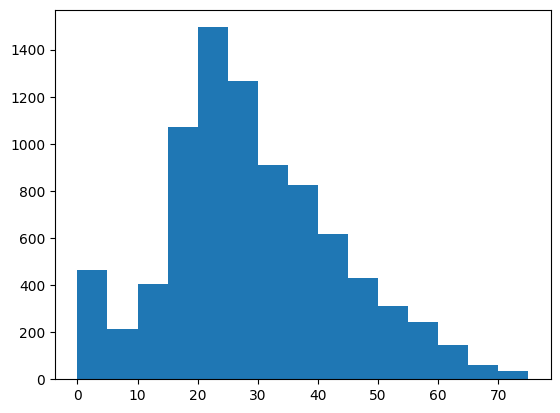

In [69]:
plt.hist(dat_train["Age"], bins=range(0,80, 5))
plt.show()

In [70]:
dat_train["Age"].fillna(dat_train["Age"].mean(), inplace=True)

### RoomService, FoodCourt, ShoppingMall, Spa and VRDeck

For the `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa` and `VRDeck` values, I will try two different solutions:
- fill mising values with 0. I will do this because as we can see below, 0 is by far the most common value in these columns. 
- fill the missing value with the mean of each of the other (known) values in the luxury amenities
We'll see later whether the more advanced method has an advantage. Just from looking at some random examples there is quite some difference in the values it eventually fills in.

In [71]:
# Checking amount of 0's in these categories
for column in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
    print(f"N. of values == 0 in \"{column}\" column: ", len(dat_train[dat_train[column] == 0]))

N. of values == 0 in "RoomService" column:  5577
N. of values == 0 in "FoodCourt" column:  5456
N. of values == 0 in "ShoppingMall" column:  5587
N. of values == 0 in "Spa" column:  5324
N. of values == 0 in "VRDeck" column:  5495


In [72]:
simple = True

if simple:
    # Filling NaN's with zeroes
    for column in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
        dat_train[column].fillna(0, inplace=True)

else:
    # Fill with mean of known amounts in other luxury spending columns
    columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    for column in columns:
        dat_train[column] = dat_train.apply(
            lambda row: row[columns].mean() if np.isnan(row[column]) else row[column],
            axis=1
        )

### HomePlanet, Destination, Cabin, VIP and CryoSleep
For the `HomePlanet`, `Destination`, `Cabin`, `VIP` and `CryoSleep` features, I will be using the mode of that feature for the group the passenger is in, since I'm assuming and seeing in the data that they'll mostly have the same home planet, destination, cabin and VIP status as their group. For the `CryoSleep`, the data seems to suggest this varies within groups as well, but using the group mode is probably still a safer bet.

In [73]:
# small function for getting mode of feature in a group
def find_mode_feature(group: int, feature: str):
    g = dat_train[dat_train["Group"] == group]
    m = g[feature].mode()

    # if each person in the group has NaN (which happens for one-person groups), we use the mode of the entire dataset
    if len(m) == 0:
        return dat_train[feature].mode()[0]
    else:
        return(g[feature].mode()[0])

features = ["HomePlanet", "Destination", "Cabin", "VIP", "CryoSleep"]

for feature in features:
    dat_train[feature] = dat_train.apply(
        lambda row: find_mode_feature(row["Group"], feature) if (str(row[feature]) == "nan") else row[feature],
        axis=1
    )

That leaves us with no missing values in the training set!

In [74]:
calc_missing()

Percent values missing:  0.0
Percent rows with missing values:  0.0
Overview of missing values:

 PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Group           0
PinG            0
dtype: int64


## Feature selection and engineering

In [75]:
# defining a function for calculating Cramer's V statistic
def cramers_V(feature: str):
    ct = pd.crosstab(dat_train[feature], dat_train["Transported"], margins=False, dropna=True)
    x2 = stats.chi2_contingency(ct, correction=False)[0]
    n = ct.sum().sum()
    cv = np.sqrt((x2/n) / (min(ct.shape) - 1))
    return(cv)

# dict of features and their correlation
feat_cor = dict()

for feature in ["HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP"]:
    feat_cor[feature] = cramers_V(feature)

for feature in ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
    c = dat_train[[feature, "Transported"]].corr()
    feat_cor[feature] = abs(c.iloc[0,1])

print(sorted(feat_cor.items(), key=lambda x:x[1], reverse=True))
    


[('Cabin', 0.8888631537383956), ('CryoSleep', 0.45800083221339233), ('RoomService', 0.24112357990296215), ('Spa', 0.21854462654893309), ('VRDeck', 0.2048736906578474), ('HomePlanet', 0.19510494531678743), ('Destination', 0.11079133761875486), ('Age', 0.07424911053933278), ('FoodCourt', 0.04558341664358489), ('VIP', 0.037260832266615314), ('ShoppingMall', 0.009391027784015404)]
